## Import Libraries

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

Using device: cuda


## Configuration

In [ ]:
# Data configuration
DATA_PATH = "Raw Data/all"
FEATURE_COLUMNS = ['FPOGX', 'FPOGY', 'LPS', 'RPS', 'LPMM', 'RPMM']

# BERT configuration
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 512

# Training configuration
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
WARMUP_STEPS = 100
MAX_GRAD_NORM = 1.0

# Cross-validation
N_SPLITS = 5


## Data Loading and Preprocessing

In [ ]:
class EyeTrackingDataset(Dataset):
    def __init__(self, data_path, feature_columns, tokenizer, max_length=512, normalize=True):
        self.data_path = data_path
        self.feature_columns = feature_columns
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.normalize = normalize
        
        self.samples = []
        self.labels = []
        self.sequences = []
        
        self._load_data()
        self._preprocess_sequences()
        
    def _load_data(self):
        """Load CSV files and extract sequences"""
        print("Loading data files...")
        
        label_map = {'literate': 1, 'illiterate': 0}
        
        for label_name, label_value in label_map.items():
            folder_path = os.path.join(self.data_path, label_name)
            if not os.path.exists(folder_path):
                print(f"Warning: {folder_path} does not exist")
                continue
                
            csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
            print(f"Found {len(csv_files)} files in {label_name} folder")
            
            for csv_file in tqdm(csv_files, desc=f"Loading {label_name} files"):
                try:
                    df = pd.read_csv(csv_file)
                    feature_data = df[self.feature_columns].copy()
                    feature_data = feature_data.fillna(feature_data.mean())
                    
                    if len(feature_data) > 0:
                        self.samples.append(csv_file)
                        self.labels.append(label_value)
                        self.sequences.append(feature_data.values)
                        
                except Exception as e:
                    print(f"Error loading {csv_file}: {e}")
                    continue
        
        print(f"Loaded {len(self.samples)} samples total")
        print(f"Label distribution: {pd.Series(self.labels).value_counts().to_dict()}")
    
    def _preprocess_sequences(self):
        """Preprocess sequences for BERT input"""
        print("Preprocessing sequences...")
        
        if self.normalize:
            all_values = np.concatenate([seq.flatten() for seq in self.sequences])
            all_values = all_values[np.isfinite(all_values)]
            
            self.global_mean = np.mean(all_values)
            self.global_std = np.std(all_values)
            
            print(f"Global mean: {self.global_mean:.4f}, Global std: {self.global_std:.4f}")
        
        self.text_sequences = []
        
        for seq in tqdm(self.sequences, desc="Converting to text"):
            if self.normalize and self.global_std > 0:
                seq_normalized = (seq - self.global_mean) / self.global_std
                seq_normalized = np.clip(seq_normalized, -5, 5)
            else:
                seq_normalized = seq
            
            text_tokens = []
            for time_step in seq_normalized:
                feature_str = " ".join([f"{val:.2f}" for val in time_step])
                text_tokens.append(f"[{feature_str}]")
            
            text_sequence = " ".join(text_tokens)
            self.text_sequences.append(text_sequence)
        
        if self.text_sequences:
            print(f"Sample text sequence (first 200 chars): {self.text_sequences[0][:200]}...")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        text = self.text_sequences[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


## Initialize Tokenizer and Load Data

In [4]:
# Initialize BERT tokenizer
print("Initializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Create dataset
print("Creating dataset...")
dataset = EyeTrackingDataset(
    data_path=DATA_PATH,
    feature_columns=FEATURE_COLUMNS,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    normalize=True
)

print(f"\nDataset created with {len(dataset)} samples")

Initializing BERT tokenizer...
Creating dataset...
Loading data files...
Found 650 files in literate folder


Loading literate files: 100%|██████████| 650/650 [00:01<00:00, 586.25it/s]


Found 849 files in illiterate folder


Loading illiterate files: 100%|██████████| 849/849 [00:01<00:00, 588.15it/s]


Loaded 1499 samples total
Label distribution: {0: 849, 1: 650}
Preprocessing sequences...
Global mean: 1.6271, Global std: 1.3663


Converting to text: 100%|██████████| 1499/1499 [00:00<00:00, 10407.19it/s]

Sample text sequence (first 200 chars): [-0.87 -0.84 -0.46 -0.46 1.62 2.11] [-1.01 -1.04 -0.48 -0.48 1.79 1.98] [-0.97 -1.08 -0.48 -0.49 1.85 2.02] [-0.97 -0.92 -0.48 -0.48 1.73 2.13] [-1.02 -0.69 -0.43 -0.43 1.85 1.84] [-0.99 -0.71 -0.44 -...

Dataset created with 1499 samples


## Model Training Functions

In [5]:
def create_data_loader(dataset, batch_size, shuffle=True):
    """Create a DataLoader for the dataset"""
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0  # Set to 0 for Windows compatibility
    )

def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(data_loader), correct_predictions / total_predictions

def evaluate_model(model, data_loader, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='binary'
    )
    
    return {
        'loss': total_loss / len(data_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }

## Cross-Validation Training

In [6]:
# Prepare for cross-validation
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
labels = np.array(dataset.labels)

# Store results
fold_results = []
all_predictions = []
all_true_labels = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(dataset)), labels)):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_SPLITS}")
    print(f"{'='*50}")
    
    # Create train and validation datasets
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    # Create data loaders
    train_loader = create_data_loader(train_dataset, BATCH_SIZE, shuffle=True)
    val_loader = create_data_loader(val_dataset, BATCH_SIZE, shuffle=False)
    
    print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
    
    # Initialize model
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )
    model.to(device)
    
    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
    total_steps = len(train_loader) * NUM_EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )
    
    # Training loop
    best_val_accuracy = 0
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
        
        # Train
        train_loss, train_accuracy = train_epoch(
            model, train_loader, optimizer, scheduler, device
        )
        
        # Evaluate
        val_results = evaluate_model(model, val_loader, device)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {val_results['loss']:.4f}, Val Acc: {val_results['accuracy']:.4f}")
        print(f"Val Precision: {val_results['precision']:.4f}, Val Recall: {val_results['recall']:.4f}, Val F1: {val_results['f1']:.4f}")
        
        # Save best model
        if val_results['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_results['accuracy']
            best_model_state = model.state_dict().copy()
    
    # Load best model and get final evaluation
    model.load_state_dict(best_model_state)
    final_results = evaluate_model(model, val_loader, device)
    
    # Store results
    fold_results.append({
        'fold': fold + 1,
        'accuracy': final_results['accuracy'],
        'precision': final_results['precision'],
        'recall': final_results['recall'],
        'f1': final_results['f1']
    })
    
    all_predictions.extend(final_results['predictions'])
    all_true_labels.extend(final_results['labels'])
    
    print(f"\nFold {fold + 1} Final Results:")
    print(f"Accuracy: {final_results['accuracy']:.4f}")
    print(f"Precision: {final_results['precision']:.4f}")
    print(f"Recall: {final_results['recall']:.4f}")
    print(f"F1-Score: {final_results['f1']:.4f}")


FOLD 1/5
Train samples: 1199, Validation samples: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00,  9.69it/s]


Train Loss: 0.6911, Train Acc: 0.5388
Val Loss: 0.6802, Val Acc: 0.5667
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00,  9.91it/s]


Train Loss: 0.6596, Train Acc: 0.5922
Val Loss: 0.5597, Val Acc: 0.7100
Val Precision: 0.6547, Val Recall: 0.7000, Val F1: 0.6766

Epoch 3/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00,  9.88it/s]


Train Loss: 0.5338, Train Acc: 0.7306
Val Loss: 0.4877, Val Acc: 0.7600
Val Precision: 0.7197, Val Recall: 0.7308, Val F1: 0.7252

Epoch 4/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00,  9.85it/s]


Train Loss: 0.4270, Train Acc: 0.8057
Val Loss: 0.4089, Val Acc: 0.8267
Val Precision: 0.8000, Val Recall: 0.8000, Val F1: 0.8000

Epoch 5/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00,  9.86it/s]


Train Loss: 0.3510, Train Acc: 0.8465
Val Loss: 0.3990, Val Acc: 0.8433
Val Precision: 0.8168, Val Recall: 0.8231, Val F1: 0.8199


Evaluating: 100%|██████████| 19/19 [00:01<00:00,  9.94it/s]



Fold 1 Final Results:
Accuracy: 0.8433
Precision: 0.8168
Recall: 0.8231
F1-Score: 0.8199

FOLD 2/5
Train samples: 1199, Validation samples: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.50it/s]


Train Loss: 0.6904, Train Acc: 0.5621
Val Loss: 0.7829, Val Acc: 0.4400
Val Precision: 0.4362, Val Recall: 1.0000, Val F1: 0.6075

Epoch 2/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.55it/s]


Train Loss: 0.6260, Train Acc: 0.6455
Val Loss: 0.5239, Val Acc: 0.7433
Val Precision: 0.6853, Val Recall: 0.7538, Val F1: 0.7179

Epoch 3/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.51it/s]


Train Loss: 0.5469, Train Acc: 0.7264
Val Loss: 0.4748, Val Acc: 0.7833
Val Precision: 0.7444, Val Recall: 0.7615, Val F1: 0.7529

Epoch 4/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.42it/s]


Train Loss: 0.4546, Train Acc: 0.7882
Val Loss: 0.3771, Val Acc: 0.8367
Val Precision: 0.8045, Val Recall: 0.8231, Val F1: 0.8137

Epoch 5/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.51it/s]


Train Loss: 0.3665, Train Acc: 0.8374
Val Loss: 0.3293, Val Acc: 0.8700
Val Precision: 0.8583, Val Recall: 0.8385, Val F1: 0.8482


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.59it/s]



Fold 2 Final Results:
Accuracy: 0.8700
Precision: 0.8583
Recall: 0.8385
F1-Score: 0.8482

FOLD 3/5
Train samples: 1199, Validation samples: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.25it/s]


Train Loss: 0.6926, Train Acc: 0.5405
Val Loss: 0.6715, Val Acc: 0.5667
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.28it/s]


Train Loss: 0.5998, Train Acc: 0.6647
Val Loss: 0.5563, Val Acc: 0.7400
Val Precision: 0.7453, Val Recall: 0.6077, Val F1: 0.6695

Epoch 3/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.26it/s]


Train Loss: 0.4811, Train Acc: 0.7765
Val Loss: 0.4988, Val Acc: 0.7500
Val Precision: 0.7350, Val Recall: 0.6615, Val F1: 0.6964

Epoch 4/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.24it/s]


Train Loss: 0.3748, Train Acc: 0.8390
Val Loss: 0.4231, Val Acc: 0.8067
Val Precision: 0.8273, Val Recall: 0.7000, Val F1: 0.7583

Epoch 5/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.25it/s]


Train Loss: 0.2961, Train Acc: 0.8832
Val Loss: 0.4092, Val Acc: 0.8167
Val Precision: 0.8099, Val Recall: 0.7538, Val F1: 0.7809


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.36it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 3 Final Results:
Accuracy: 0.8167
Precision: 0.8099
Recall: 0.7538
F1-Score: 0.7809

FOLD 4/5
Train samples: 1199, Validation samples: 300

Epoch 1/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.70it/s]


Train Loss: 0.6990, Train Acc: 0.5396
Val Loss: 0.6717, Val Acc: 0.6800
Val Precision: 0.6328, Val Recall: 0.6231, Val F1: 0.6279

Epoch 2/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.67it/s]


Train Loss: 0.6259, Train Acc: 0.6355
Val Loss: 0.5649, Val Acc: 0.7233
Val Precision: 0.7640, Val Recall: 0.5231, Val F1: 0.6210

Epoch 3/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.61it/s]


Train Loss: 0.5293, Train Acc: 0.7323
Val Loss: 0.5080, Val Acc: 0.7300
Val Precision: 0.6384, Val Recall: 0.8692, Val F1: 0.7362

Epoch 4/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.67it/s]


Train Loss: 0.4159, Train Acc: 0.8157
Val Loss: 0.3730, Val Acc: 0.8267
Val Precision: 0.7532, Val Recall: 0.8923, Val F1: 0.8169

Epoch 5/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.64it/s]


Train Loss: 0.3014, Train Acc: 0.8916
Val Loss: 0.3176, Val Acc: 0.8633
Val Precision: 0.8397, Val Recall: 0.8462, Val F1: 0.8429


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.69it/s]



Fold 4 Final Results:
Accuracy: 0.8633
Precision: 0.8397
Recall: 0.8462
F1-Score: 0.8429

FOLD 5/5
Train samples: 1200, Validation samples: 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.51it/s]


Train Loss: 0.6864, Train Acc: 0.5600
Val Loss: 0.6303, Val Acc: 0.6321
Val Precision: 0.7273, Val Recall: 0.2462, Val F1: 0.3678

Epoch 2/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.59it/s]


Train Loss: 0.5650, Train Acc: 0.7150
Val Loss: 0.5678, Val Acc: 0.7057
Val Precision: 0.7283, Val Recall: 0.5154, Val F1: 0.6036

Epoch 3/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]


Train Loss: 0.4673, Train Acc: 0.7833
Val Loss: 0.5742, Val Acc: 0.7458
Val Precision: 0.8553, Val Recall: 0.5000, Val F1: 0.6311

Epoch 4/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.49it/s]


Train Loss: 0.3729, Train Acc: 0.8450
Val Loss: 0.4041, Val Acc: 0.8161
Val Precision: 0.8151, Val Recall: 0.7462, Val F1: 0.7791

Epoch 5/5


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.61it/s]


Train Loss: 0.2880, Train Acc: 0.8925
Val Loss: 0.3851, Val Acc: 0.8361
Val Precision: 0.8462, Val Recall: 0.7615, Val F1: 0.8016


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.59it/s]


Fold 5 Final Results:
Accuracy: 0.8361
Precision: 0.8462
Recall: 0.7615
F1-Score: 0.8016


## Results Analysis

In [7]:
# Calculate overall statistics
results_df = pd.DataFrame(fold_results)

print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*60)

print("\nPer-Fold Results:")
print(results_df.to_string(index=False, float_format='%.4f'))

print("\nOverall Statistics:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

# Calculate overall confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
overall_accuracy = accuracy_score(all_true_labels, all_predictions)

print(f"\nOverall Accuracy (all folds): {overall_accuracy:.4f}")
print("\nConfusion Matrix:")
print(cm)


CROSS-VALIDATION RESULTS SUMMARY

Per-Fold Results:
 fold  accuracy  precision  recall     f1
    1    0.8433     0.8168  0.8231 0.8199
    2    0.8700     0.8583  0.8385 0.8482
    3    0.8167     0.8099  0.7538 0.7809
    4    0.8633     0.8397  0.8462 0.8429
    5    0.8361     0.8462  0.7615 0.8016

Overall Statistics:
Accuracy: 0.8459 ± 0.0215
Precision: 0.8342 ± 0.0203
Recall: 0.8046 ± 0.0437
F1: 0.8187 ± 0.0282

Overall Accuracy (all folds): 0.8459

Confusion Matrix:
[[745 104]
 [127 523]]


## Visualization

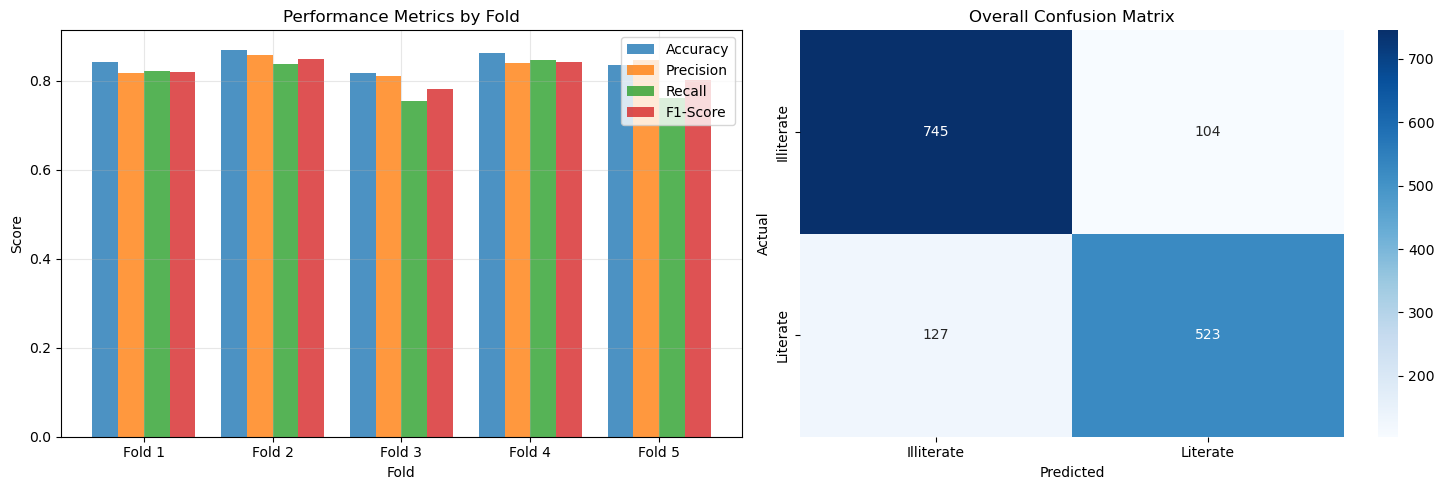

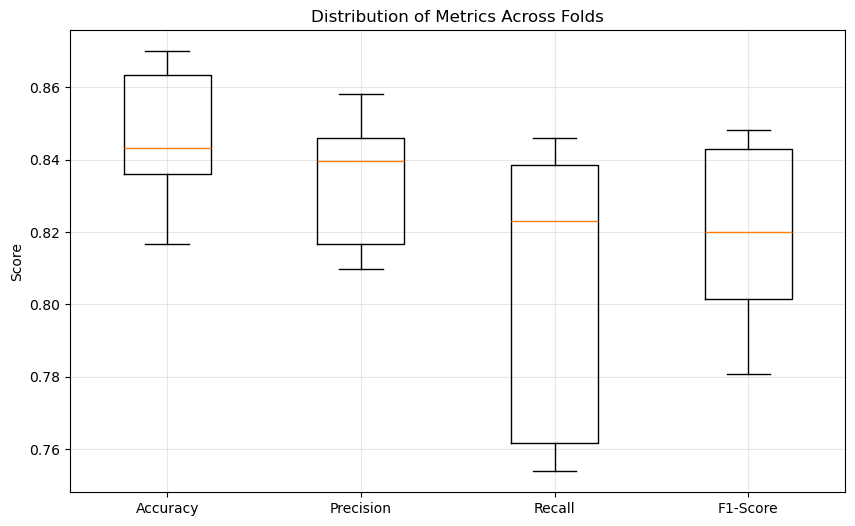

In [8]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Metrics by fold
ax1 = axes[0]
x = np.arange(len(results_df))
width = 0.2

ax1.bar(x - 1.5*width, results_df['accuracy'], width, label='Accuracy', alpha=0.8)
ax1.bar(x - 0.5*width, results_df['precision'], width, label='Precision', alpha=0.8)
ax1.bar(x + 0.5*width, results_df['recall'], width, label='Recall', alpha=0.8)
ax1.bar(x + 1.5*width, results_df['f1'], width, label='F1-Score', alpha=0.8)

ax1.set_xlabel('Fold')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics by Fold')
ax1.set_xticks(x)
ax1.set_xticklabels([f'Fold {i+1}' for i in range(len(results_df))])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Confusion matrix
ax2 = axes[1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Illiterate', 'Literate'],
            yticklabels=['Illiterate', 'Literate'])
ax2.set_title('Overall Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Box plot of metrics across folds
plt.figure(figsize=(10, 6))
metrics_data = [results_df['accuracy'], results_df['precision'], 
                results_df['recall'], results_df['f1']]
plt.boxplot(metrics_data, labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
plt.title('Distribution of Metrics Across Folds')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.show()

## Model Analysis and Feature Importance

In [9]:
# Analyze some sample predictions
print("\nSample Predictions Analysis:")
print("-" * 40)

# Get a few samples for analysis
sample_indices = np.random.choice(len(dataset), size=min(5, len(dataset)), replace=False)

for idx in sample_indices:
    sample = dataset[idx]
    true_label = sample['labels'].item()
    
    # Get prediction (using the last trained model)
    model.eval()
    with torch.no_grad():
        input_ids = sample['input_ids'].unsqueeze(0).to(device)
        attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_label = torch.argmax(logits, dim=-1).item()
        confidence = probabilities[0][predicted_label].item()
    
    label_names = {0: 'Illiterate', 1: 'Literate'}
    
    print(f"Sample {idx}:")
    print(f"  True Label: {label_names[true_label]}")
    print(f"  Predicted: {label_names[predicted_label]} (confidence: {confidence:.3f})")
    print(f"  Correct: {'✓' if true_label == predicted_label else '✗'}")
    print(f"  File: {dataset.samples[idx]}")
    print()


Sample Predictions Analysis:
----------------------------------------
Sample 1116:
  True Label: Illiterate
  Predicted: Illiterate (confidence: 0.973)
  Correct: ✓
  File: Raw Data/all\illiterate\user_25_question_25.csv

Sample 1395:
  True Label: Illiterate
  Predicted: Illiterate (confidence: 0.936)
  Correct: ✓
  File: Raw Data/all\illiterate\user_3_question_6.csv

Sample 422:
  True Label: Literate
  Predicted: Literate (confidence: 0.942)
  Correct: ✓
  File: Raw Data/all\literate\user_29_question_3.csv

Sample 413:
  True Label: Literate
  Predicted: Literate (confidence: 0.942)
  Correct: ✓
  File: Raw Data/all\literate\user_29_question_21.csv

Sample 451:
  True Label: Literate
  Predicted: Literate (confidence: 0.921)
  Correct: ✓
  File: Raw Data/all\literate\user_31_question_10.csv



## Data Statistics and Insights

Dataset Statistics:
Number of samples: 1499
Number of features: 6
Feature columns: ['FPOGX', 'FPOGY', 'LPS', 'RPS', 'LPMM', 'RPMM']

Sequence Length Statistics:
Mean length: 55.4
Median length: 43.0
Min length: 5
Max length: 449
Std deviation: 43.0

Text Sequence Statistics:
Mean text length (tokens): 332.3
Max text length (tokens): 2694
Sequences exceeding BERT max length (512): 242


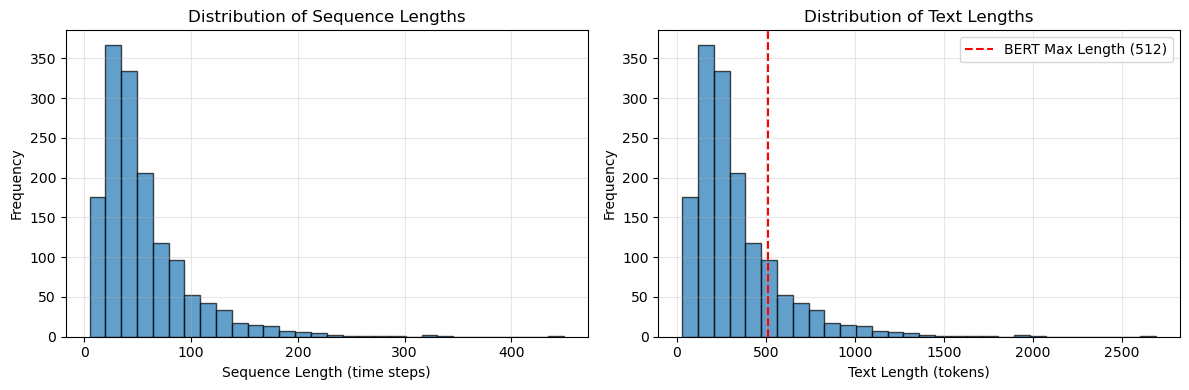

In [10]:
# Analyze sequence lengths and feature statistics
sequence_lengths = [len(seq) for seq in dataset.sequences]
text_lengths = [len(text.split()) for text in dataset.text_sequences]

print("Dataset Statistics:")
print(f"Number of samples: {len(dataset)}")
print(f"Number of features: {len(FEATURE_COLUMNS)}")
print(f"Feature columns: {FEATURE_COLUMNS}")

print(f"\nSequence Length Statistics:")
print(f"Mean length: {np.mean(sequence_lengths):.1f}")
print(f"Median length: {np.median(sequence_lengths):.1f}")
print(f"Min length: {np.min(sequence_lengths)}")
print(f"Max length: {np.max(sequence_lengths)}")
print(f"Std deviation: {np.std(sequence_lengths):.1f}")

print(f"\nText Sequence Statistics:")
print(f"Mean text length (tokens): {np.mean(text_lengths):.1f}")
print(f"Max text length (tokens): {np.max(text_lengths)}")
print(f"Sequences exceeding BERT max length ({MAX_LENGTH}): {sum(1 for length in text_lengths if length > MAX_LENGTH)}")

# Plot sequence length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(sequence_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length (time steps)')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(text_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=MAX_LENGTH, color='red', linestyle='--', label=f'BERT Max Length ({MAX_LENGTH})')
plt.xlabel('Text Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [11]:
# Save results to CSV
results_df.to_csv('bert_cv_results.csv', index=False)
print("Results saved to 'bert_cv_results.csv'")

# Save detailed predictions
predictions_df = pd.DataFrame({
    'true_label': all_true_labels,
    'predicted_label': all_predictions,
    'correct': np.array(all_true_labels) == np.array(all_predictions)
})
predictions_df.to_csv('bert_predictions.csv', index=False)
print("Predictions saved to 'bert_predictions.csv'")

print("\nModel training and evaluation completed successfully!")

Results saved to 'bert_cv_results.csv'
Predictions saved to 'bert_predictions.csv'

Model training and evaluation completed successfully!
